## Trabalho de Deep Learning
## Previsão do Despacho das termelétricas a partir de variáveis meteorológicas

_________________________

In [ ]:
#from google.colab import drive
import os
import glob
import time

import numpy as np
from numpy.random import seed
import pandas as pd

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import joblib as jb

import matplotlib.pyplot as plt
from IPython.display import display, Image
import seaborn as sns
sns.set_theme()

In [ ]:
np.random.seed(42)

_________________________

## I. Business Understanding

**Objetivo: Previsão da necessidade de despacho de usinas termelétricas em um sistema elétrico com predominância de fontes renováveis.**

### Contexto

O Brasil possui um grande e diverso potencial energético, com parte expressiva, tanto atual quanto potencialmente, proveniente de fontes renováveis. Estas, em sua maioria, possuem a característica de serem suscetíveis às condições climáticas e, portanto, tendem a uma maior oscilação na geração. 

Segundo a Empresa de Pesquisa Energética (EPE), em 2020, aproximadamente 74% da capacidade instalada do país estava associada a fontes que se enquadram no descrito acima, com destaque para as hidrelétricas, que representam 62,53% da capacidade total.

In [ ]:
#importando dados da capacidade instalada em valor absoluto
df_capacidade = pd.read_excel('material/epe/Anexo I - Capacidade instalada.xlsx', sheet_name='resumo_capacidade_mw', index_col=0, engine='openpyxl').transpose()
df_capacidade.columns.name = 'Fonte'

#importando dados da capacidade instalada em percentual
df_capacidadeperc = pd.read_excel('material/epe/Anexo I - Capacidade instalada.xlsx', sheet_name='resumo_capacidade_%', index_col=0, engine='openpyxl').transpose()
df_capacidadeperc.columns.name = 'Fonte'

Text(0.5, 1.0, 'Participação de cada Fonte na Capacidade Instalada - 2020')

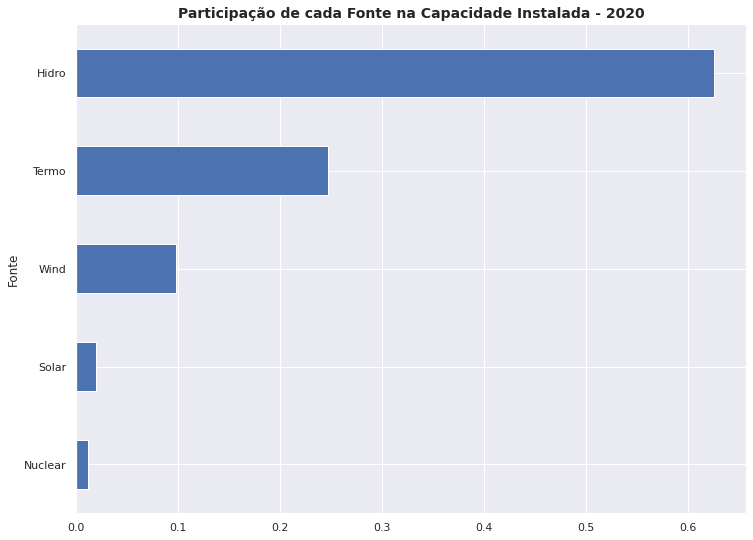

In [ ]:
#plotando a capacidade instalada por fonte
df_capacidadeperc2020 = df_capacidadeperc[df_capacidadeperc.index=='2020'].transpose().sort_values(by='2020', ascending=True)
df_capacidadeperc2020.plot(kind = 'barh', figsize=(12,9), legend=False)
plt.title(label='Participação de cada Fonte na Capacidade Instalada - 2020', fontdict={'fontsize': 14, 'fontweight': 'bold'})

Ao longo dos anos há um crescimento do consumo de energia elétrica no país, variável esta que é fortemente relacionada com o nível de atividade econômica. 

Apesar dos desafios impostos pelas mudanças climáticas e dos esforços para se ter cada vez mais efiência energética na geração, transmissão e no consumo de energia, é esperado que o consumo de energia permenaceça seguindo uma trajetória de crescimento.

Segundo projeções do Operador Nacional do Setor Elétrico (ONS), da Câmara de Comercialização de Energia Elétrica (CCEE) e da EPE, a demanda de energia elétrica (carga) deve crescer 2,7% em 2022 e, em média, 3,4% ao ano no período 2022-2026.

Nota-se que, com exceção da nuclear, a capacidade instalada de geração também apresentou um trajetória de crescimento para todas as fontes. A energia eólica destaca-se pelo expressivo crescimento a partir de 2014.

Text(0.5, 1.0, 'Evolução Anual da Capacidade Instalada por Fonte')

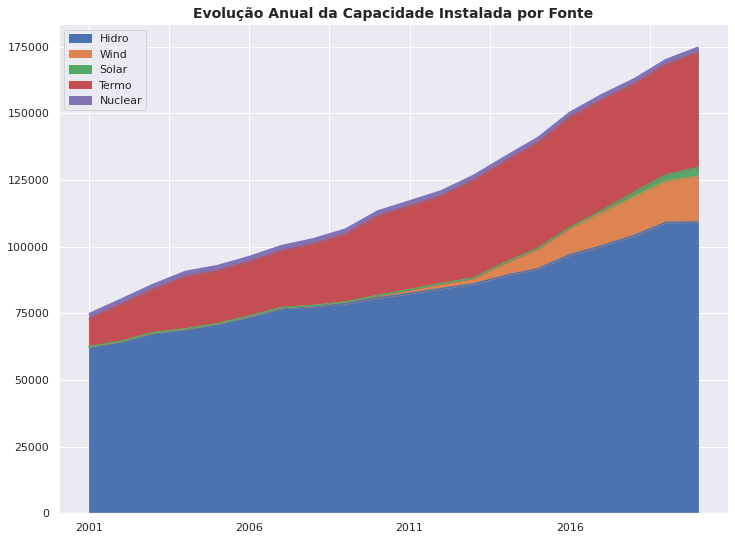

In [ ]:
df_capacidade.plot(kind='area', figsize=(12,9))
plt.legend(title='')
plt.title(label='Evolução Anual da Capacidade Instalada por Fonte', fontdict={'fontsize': 14, 'fontweight': 'bold'})

Apesar do incremento de participação das energias solar e eólica na matriz energética nacional ao longo dos anos, percebe-se que as hidrelétricas permaneceram como a principal fonte de energia.

Text(0.5, 1.0, 'Evolução Anual da Participação das Fontes na Capacidade Instalada')

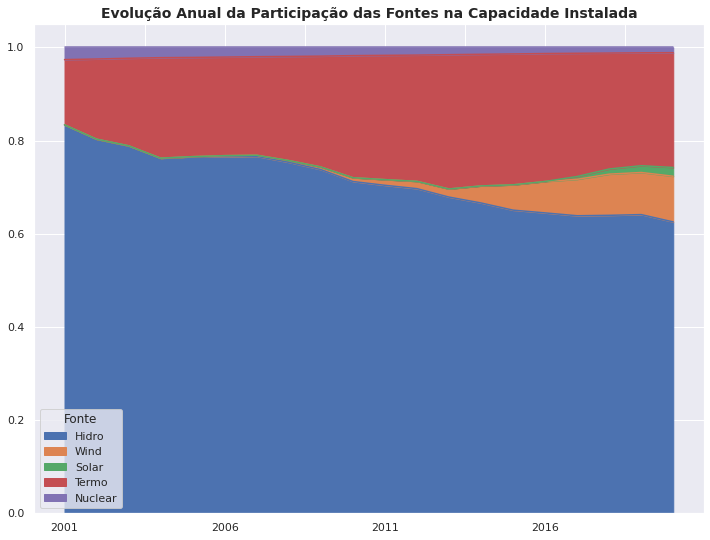

In [ ]:
df_capacidadeperc.plot(kind = 'area', figsize=(12,9))
plt.title(label='Evolução Anual da Participação das Fontes na Capacidade Instalada', fontdict={'fontsize': 14, 'fontweight': 'bold'})

Considerando a tendência observada e os esforços internacionais visando mitigar o impacto das mudanças climáticas, é esperado que as fontes renováveis, em especial hidráulica, solar e eólica, permanecerão tendo importante papel na matriz energética brasileira nos anos vindouros. Em função disso, o sistema permanecerá vulnerável às condições climáticas e, em especial, aos eventos extremos, estes cada vez mais comuns. 

A escassez de chuvas, por exemplo, em determinados períodos do ano reduz a capacidade de geração do parque hidrelétrico, o que em anos de estiagem mais severa, tem levado a crises energéticas frequentes no país.

No caso da energia solar, observa-se uma variação no fornecimento dentro de um mesmo dia, ocasionando o fenômeno da "Curva do Pato", observado em sistemas nos quais a energia solar tem participação significativa. Esse fenômeno foi observado no Sistema Integrado da Califórnia, o que levou a elevação no custo da energia elétrica naquele estado americano, como consequência do maior despacho de térmicas menos eficientes e mais caras, mas que respondem mais rapidamente à variação da geração de energia solar.

A situação acima não é atualmente o caso do Brasil. Entretanto, conforme a energia solar ganhe maior relevância, isto pode se tornar realidade para o sistema elétrico brasileiro.

De modo a garantir o bom funcionamento do sistema e evitar situações de restrição na oferta de energia elétrica, tornam-se relevantes a aplicação de modelos preditivos para assegurar a otimização da alocação das fontes. Além disso, é necessário que existam alternativas, como as termelétricas, capazes de suprir a carga necessária nos momentos de baixa geração das renováveis e propiciar flexibilidade ao sistema.

O objeto deste trabalho é implementar modelos para previsão da necessidade de despacho de energia térmica por subsistema, tendo como base principalmente as condições climáticas. 

Para alcançar este objetivo, foram coletados dados referentes ao período de 2013 a 2021 de despacho de energia térmica e de carga de energia disponíveis no site da ONS, bem como dados meteorológicos disponíveis no site do InMET.

## Análise dos dados
 

### Importando dados de despacho de energia térmica

Os dados de despacho térmico foram obtidos no site da ONS. O dataset utilizado apresenta, dentre outros, os valores programados e efetivamente gerados para cada usina no território nacional.

In [ ]:
# importação do arquivo consolidado
df_term=pd.read_csv('Datasets/despacho_termica_consolidado_2013-2021.csv')

In [ ]:
#verifica o dataframe criado
df_term.head()

,din_instante,nom_tipopatamar,id_subsistema,nom_subsistema,nom_usina,cod_usinaplanejamento,val_proggeracao,val_progordemmerito,val_progordemdemeritoref,val_proginflexibilidade,...,val_verifrazaoeletrica,val_verifgarantiaenergetica,val_verifgfom,val_verifreposicaoperdas,val_verifexportacao,val_verifreservapotencia,val_atendsatisfatoriorpo,val_verifgsub,val_verifunitcommitment,val_verifconstrainedoff
0,2013-01-01 00:00:00,LEVE,N,NORTE,Geramar I,73.0,159.0,0.0,0.0,0.0,...,0.0,156.64,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
1,2013-01-01 00:00:00,LEVE,N,NORTE,Geramar II,70.0,159.0,0.0,0.0,0.0,...,0.0,155.64,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
2,2013-01-01 00:00:00,LEVE,N,NORTE,Porto do Itaqui,176.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
3,2013-01-01 00:00:00,LEVE,NE,NORDESTE,Altos,109.0,11.0,0.0,0.0,0.0,...,0.0,9.52,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
4,2013-01-01 00:00:00,LEVE,NE,NORDESTE,Aracati,111.0,12.0,0.0,0.0,0.0,...,0.0,6.90,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


### Importando dados meteorológicos

Os dados metereológicos foram obtidos no InMET. São 610 estações automáticas espalhadas pelo território nacional que fazem a medição horária de varíaveis como precipitação, radiação, temperatura e velocidade do vento.

**Dados das estações automáticas**

In [ ]:
#cria um dataframe com as estações
df_estacoes = pd.read_csv('Datasets/automatic_stations_codes.csv',
                  encoding = 'UTF-8', 
                  delimiter = ';',
                  decimal = ',',
                  low_memory=False)

#eliminando e renomeando algumas colunas
df_estacoes.drop(columns=['ESTACAO', 'LATITUDE', 'LONGITUDE', 'ALTITUDE'], inplace=True)
df_estacoes.rename(columns = {'CODIGO': 'ESTACAO'}, inplace=True)

#qtd de estações
df_estacoes['ESTACAO'].nunique()

610

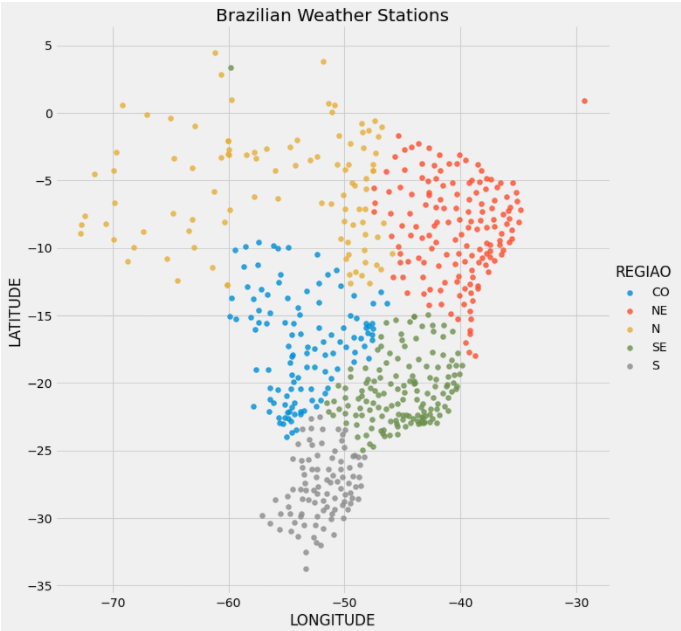

In [ ]:
#distribuição geográfica das estações
display(Image('images/distribuicao_estacoes_automaticas.png', width=700))

**Dados meteorológicos**

O dataset importado sofreu uma série de tratamentos visando reduzir o seu tamanho e facilitar o manuseio. Foram consolidados os dados de todas as estações (aproximadamente 600 csv) em somente um arquivo e eliminadas colunas que não serão utilizadas no trabalho.

In [ ]:
# importa arquivo consolidado
df_tempo=pd.read_csv('Datasets/tempo_consolidado-2012-2021_ajustado.csv')

In [ ]:
#verifica o dataframe criado
df_tempo.head()

,Data Medicao,Hora Medicao,"PRECIPITACAO TOTAL, HORARIO(mm)",RADIACAO GLOBAL(Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)","VENTO, VELOCIDADE HORARIA(m/s)",ESTACAO,REGIAO,UF
0,2012-01-01 00:00:00,0,0.0,-3.302,19.9,3.0,A001,CO,DF
1,2012-01-01 01:00:00,100,0.0,-2.534,19.7,2.5,A001,CO,DF
2,2012-01-01 02:00:00,200,0.0,-2.844,19.7,3.0,A001,CO,DF
3,2012-01-01 03:00:00,300,0.0,-2.704,19.6,3.4,A001,CO,DF
4,2012-01-01 04:00:00,400,0.0,-2.259,19.1,3.2,A001,CO,DF


### Conhecendo os dados

#### Dados de térmicas

In [ ]:
#informações gerais sobre o dataset
df_term.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8550258 entries, 0 to 8550257
Data columns (total 32 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   din_instante                 object 
 1   nom_tipopatamar              object 
 2   id_subsistema                object 
 3   nom_subsistema               object 
 4   nom_usina                    object 
 5   cod_usinaplanejamento        float64
 6   val_proggeracao              float64
 7   val_progordemmerito          float64
 8   val_progordemdemeritoref     float64
 9   val_proginflexibilidade      float64
 10  val_prograzaoeletrica        float64
 11  val_proggarantiaenergetica   float64
 12  val_proggfom                 float64
 13  val_progreposicaoperdas      float64
 14  val_progexportacao           float64
 15  val_progreservapotencia      float64
 16  val_proggsub                 float64
 17  val_progunitcommitment       float64
 18  val_progconstrainedoff       float64
 19  

In [ ]:
#estatística descritiva das variáveis do dataset
df_term.describe()

,cod_usinaplanejamento,val_proggeracao,val_progordemmerito,val_progordemdemeritoref,val_proginflexibilidade,val_prograzaoeletrica,val_proggarantiaenergetica,val_proggfom,val_progreposicaoperdas,val_progexportacao,...,val_verifrazaoeletrica,val_verifgarantiaenergetica,val_verifgfom,val_verifreposicaoperdas,val_verifexportacao,val_verifreservapotencia,val_atendsatisfatoriorpo,val_verifgsub,val_verifunitcommitment,val_verifconstrainedoff
count,7.332901e+06,8.550258e+06,8.550258e+06,8.550258e+06,8.550258e+06,8.550258e+06,8.550258e+06,8.550258e+06,8.550258e+06,8.550258e+06,...,8.550258e+06,8.550258e+06,8.550258e+06,8.550258e+06,8.550258e+06,8.550258e+06,8.550258e+06,8.550258e+06,1.857600e+06,8.550258e+06
mean,1.194540e+02,1.065126e+02,7.034474e+01,8.992963e+01,4.470036e+01,3.277666e+00,1.471185e+01,2.132413e+00,6.118646e-03,9.710923e-02,...,3.233933e+00,1.382514e+01,2.000843e+00,5.016465e-03,8.919377e-02,4.345937e-01,2.413144e-03,6.224954e-02,3.028334e+00,1.450776e+00
std,6.979072e+01,1.921632e+02,1.805764e+02,2.037356e+02,1.435891e+02,2.825869e+01,6.921047e+01,2.778450e+01,1.023649e+00,5.175811e+00,...,2.751441e+01,6.630514e+01,2.654598e+01,8.328671e-01,4.925170e+00,1.215860e+01,5.443001e-02,3.139929e+00,3.029599e+01,3.139117e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-7.000000e+01,-3.350000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.190000e+02,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.700000e+02,1.470000e+02,4.000000e+00,7.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.470000e+02,1.525000e+03,1.516000e+03,9.999000e+03,1.525000e+03,1.998000e+03,1.516000e+03,8.900000e+02,3.980000e+02,5.200000e+02,...,8.815230e+02,1.578616e+03,8.799020e+02,3.980000e+02,5.200000e+02,8.014800e+02,2.000000e+00,4.500000e+02,1.339456e+03,6.823769e+04


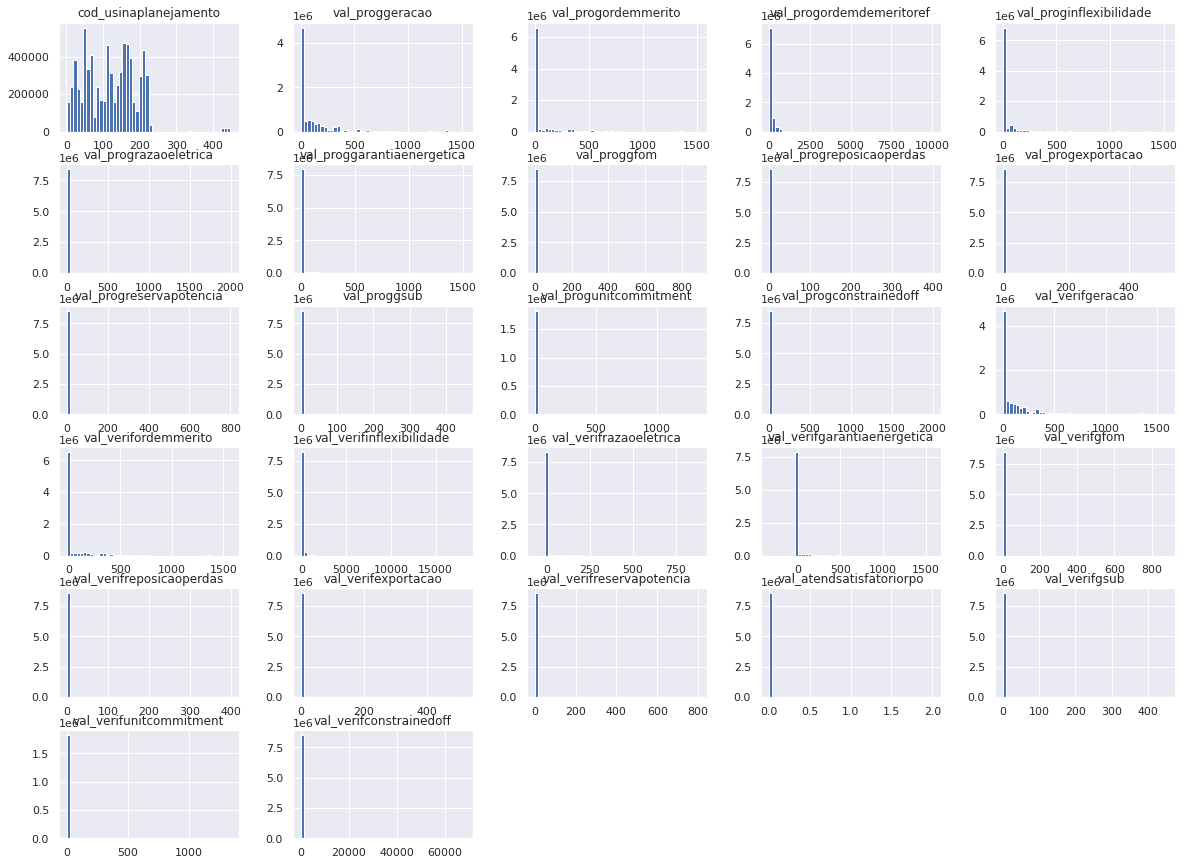

In [ ]:
#hitograma dos dados de térmicas
df_term.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
#colunas do dataset
df_term.columns

Index(['din_instante', 'nom_tipopatamar', 'id_subsistema', 'nom_subsistema',
       'nom_usina', 'cod_usinaplanejamento', 'val_proggeracao',
       'val_progordemmerito', 'val_progordemdemeritoref',
       'val_proginflexibilidade', 'val_prograzaoeletrica',
       'val_proggarantiaenergetica', 'val_proggfom', 'val_progreposicaoperdas',
       'val_progexportacao', 'val_progreservapotencia', 'val_proggsub',
       'val_progunitcommitment', 'val_progconstrainedoff', 'val_verifgeracao',
       'val_verifordemmerito', 'val_verifinflexibilidade',
       'val_verifrazaoeletrica', 'val_verifgarantiaenergetica',
       'val_verifgfom', 'val_verifreposicaoperdas', 'val_verifexportacao',
       'val_verifreservapotencia', 'val_atendsatisfatoriorpo', 'val_verifgsub',
       'val_verifunitcommitment', 'val_verifconstrainedoff'],
      dtype='object')

In [ ]:
# Resumir o Dataset às variáveis mais relevantes e separação do benchmark
df_term=df_term.drop(['nom_usina', 'cod_usinaplanejamento',
       'val_progordemmerito', 'val_progordemdemeritoref',
       'val_proginflexibilidade', 'val_prograzaoeletrica',
       'val_proggarantiaenergetica', 'val_proggfom', 'val_progreposicaoperdas',
       'val_progexportacao', 'val_progreservapotencia', 'val_proggsub',
       'val_progunitcommitment', 'val_progconstrainedoff', 
       'val_verifordemmerito', 'val_verifinflexibilidade',
       'val_verifrazaoeletrica', 'val_verifgarantiaenergetica',
       'val_verifgfom', 'val_verifreposicaoperdas', 'val_verifexportacao',
       'val_verifreservapotencia', 'val_atendsatisfatoriorpo', 'val_verifgsub',
       'val_verifunitcommitment', 'val_verifconstrainedoff'],axis=1)
df_term['din_instante'] = pd.to_datetime(df_term['din_instante'],format="%Y-%m-%d %H:%M:%S") 
prog_ger=df_term.drop(['val_verifgeracao'],axis=1)
df_term=df_term.drop(['val_proggeracao'],axis=1)
df_term

,din_instante,nom_tipopatamar,id_subsistema,nom_subsistema,val_verifgeracao
0,2013-01-01 00:00:00,LEVE,N,NORTE,156.64
1,2013-01-01 00:00:00,LEVE,N,NORTE,155.64
2,2013-01-01 00:00:00,LEVE,N,NORTE,0.00
3,2013-01-01 00:00:00,LEVE,NE,NORDESTE,9.52
4,2013-01-01 00:00:00,LEVE,NE,NORDESTE,6.90
...,...,...,...,...,...
8550253,2021-12-31 23:00:00,MÉDIA,SE,SUDESTE,0.00
8550254,2021-12-31 23:00:00,MÉDIA,SE,SUDESTE,0.00
8550255,2021-12-31 23:00:00,MÉDIA,SE,SUDESTE,0.00
8550256,2021-12-31 23:00:00,MÉDIA,SE,SUDESTE,0.00


In [ ]:
#Quantos valores únicos tem a variáveis id_subsistema?
df_term['id_subsistema'].unique()

array(['N', 'NE', 'S', 'SE'], dtype=object)

In [ ]:
#agrupando os dados por subsistema e data - soma do valor gerado
df_term=df_term.groupby(['id_subsistema','din_instante']).sum().reset_index()
df_term['din_instante']=pd.to_datetime(df_term['din_instante'])
df_term

,id_subsistema,din_instante,val_verifgeracao
0,N,2013-01-01 00:00:00,312.2800
1,N,2013-01-01 01:00:00,313.0900
2,N,2013-01-01 02:00:00,312.7000
3,N,2013-01-01 03:00:00,312.8500
4,N,2013-01-01 04:00:00,312.6900
...,...,...,...
314823,SE,2021-12-31 19:00:00,6226.0485
314824,SE,2021-12-31 20:00:00,6242.9475
314825,SE,2021-12-31 21:00:00,6097.6165
314826,SE,2021-12-31 22:00:00,5907.5920


In [ ]:
#fazendo o mesmo no benchmark
prog_ger=prog_ger.groupby(['id_subsistema','din_instante']).sum().reset_index()
prog_ger['din_instante']=pd.to_datetime(prog_ger['din_instante'])
prog_ger

,id_subsistema,din_instante,val_proggeracao
0,N,2013-01-01 00:00:00,318.0
1,N,2013-01-01 01:00:00,318.0
2,N,2013-01-01 02:00:00,318.0
3,N,2013-01-01 03:00:00,318.0
4,N,2013-01-01 04:00:00,318.0
...,...,...,...
314823,SE,2021-12-31 19:00:00,6259.0
314824,SE,2021-12-31 20:00:00,6259.0
314825,SE,2021-12-31 21:00:00,6174.0
314826,SE,2021-12-31 22:00:00,6001.5


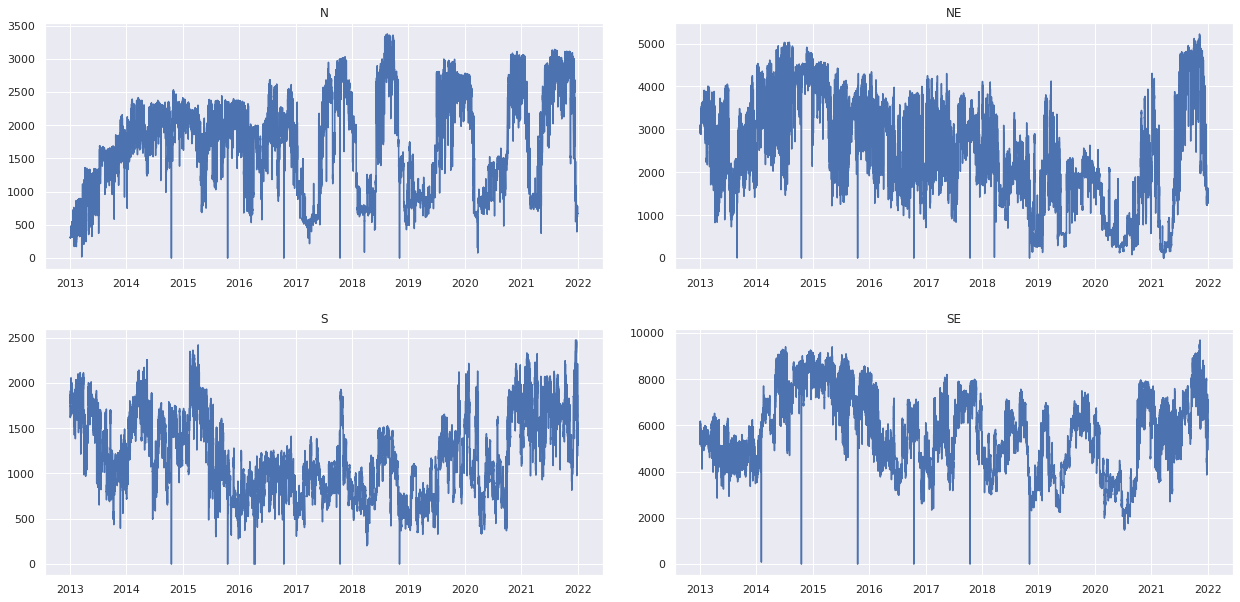

In [ ]:
#despacho das térmicas por subsistema

j=0
k=0
fig, ax = plt.subplots(2,2)
fig.set_size_inches(18, 9)
fig.tight_layout(pad=3.0)
for i in df_term['id_subsistema'].unique():
  ax[j,k].plot(df_term['din_instante'].loc[df_term['id_subsistema']==i],df_term['val_verifgeracao'].loc[df_term['id_subsistema']==i])
  ax[j,k].set_title(i)
  if k%2==0:
    k=k+1
  else:
    j=j+1
    k=0
plt.show()


#### Dados climáticos

In [ ]:
#informações gerais sobre o dataset
df_tempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46462008 entries, 0 to 46462007
Data columns (total 9 columns):
 #   Column                                       Dtype  
---  ------                                       -----  
 0   Data Medicao                                 object 
 1   Hora Medicao                                 int64  
 2   PRECIPITACAO TOTAL, HORARIO(mm)              float64
 3   RADIACAO GLOBAL(Kj/m²)                       float64
 4   TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)  float64
 5   VENTO, VELOCIDADE HORARIA(m/s)               float64
 6   ESTACAO                                      object 
 7   REGIAO                                       object 
 8   UF                                           object 
dtypes: float64(4), int64(1), object(4)
memory usage: 3.1+ GB


In [ ]:
#estatísticas descritivas do dataset
df_tempo.describe()

,Hora Medicao,"PRECIPITACAO TOTAL, HORARIO(mm)",RADIACAO GLOBAL(Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)","VENTO, VELOCIDADE HORARIA(m/s)"
count,4.646201e+07,3.778514e+07,3.949493e+07,4.013946e+07,3.908960e+07
mean,1.150000e+03,1.535795e-01,7.712714e+02,2.351850e+01,1.967347e+00
std,6.922187e+02,1.273314e+00,1.083338e+03,5.584240e+00,1.707091e+00
min,0.000000e+00,0.000000e+00,-1.776000e+01,-9.000000e+00,0.000000e+00
25%,5.750000e+02,0.000000e+00,-3.480000e+00,2.020000e+01,6.000000e-01
50%,1.150000e+03,0.000000e+00,3.921200e+01,2.360000e+01,1.700000e+00
75%,1.725000e+03,0.000000e+00,1.455815e+03,2.720000e+01,2.900000e+00
max,2.300000e+03,9.720000e+01,2.310488e+04,4.500000e+01,4.340000e+01


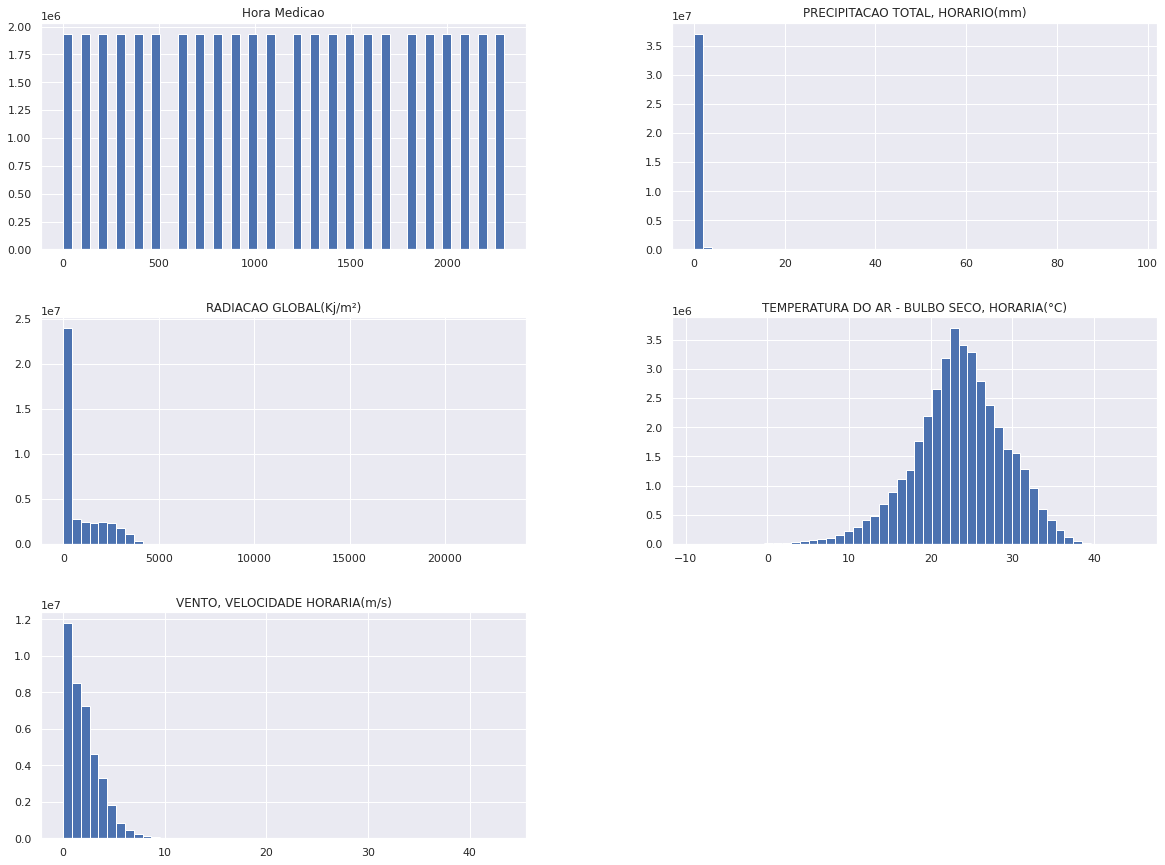

In [ ]:
df_tempo.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
#Transformar a coluna de data em variável tempo

df_tempo['Data Medicao'] = pd.to_datetime(df_tempo['Data Medicao'],format="%Y-%m-%d") 
df_tempo.head()

,Data Medicao,Hora Medicao,"PRECIPITACAO TOTAL, HORARIO(mm)",RADIACAO GLOBAL(Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)","VENTO, VELOCIDADE HORARIA(m/s)",ESTACAO,REGIAO,UF
0,2012-01-01 00:00:00,0,0.0,-3.302,19.9,3.0,A001,CO,DF
1,2012-01-01 01:00:00,100,0.0,-2.534,19.7,2.5,A001,CO,DF
2,2012-01-01 02:00:00,200,0.0,-2.844,19.7,3.0,A001,CO,DF
3,2012-01-01 03:00:00,300,0.0,-2.704,19.6,3.4,A001,CO,DF
4,2012-01-01 04:00:00,400,0.0,-2.259,19.1,3.2,A001,CO,DF


In [ ]:
df_tempo.columns

Index(['Data Medicao', 'Hora Medicao', 'PRECIPITACAO TOTAL, HORARIO(mm)',
       'RADIACAO GLOBAL(Kj/m²)', 'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)',
       'VENTO, VELOCIDADE HORARIA(m/s)', 'ESTACAO', 'REGIAO', 'UF'],
      dtype='object')

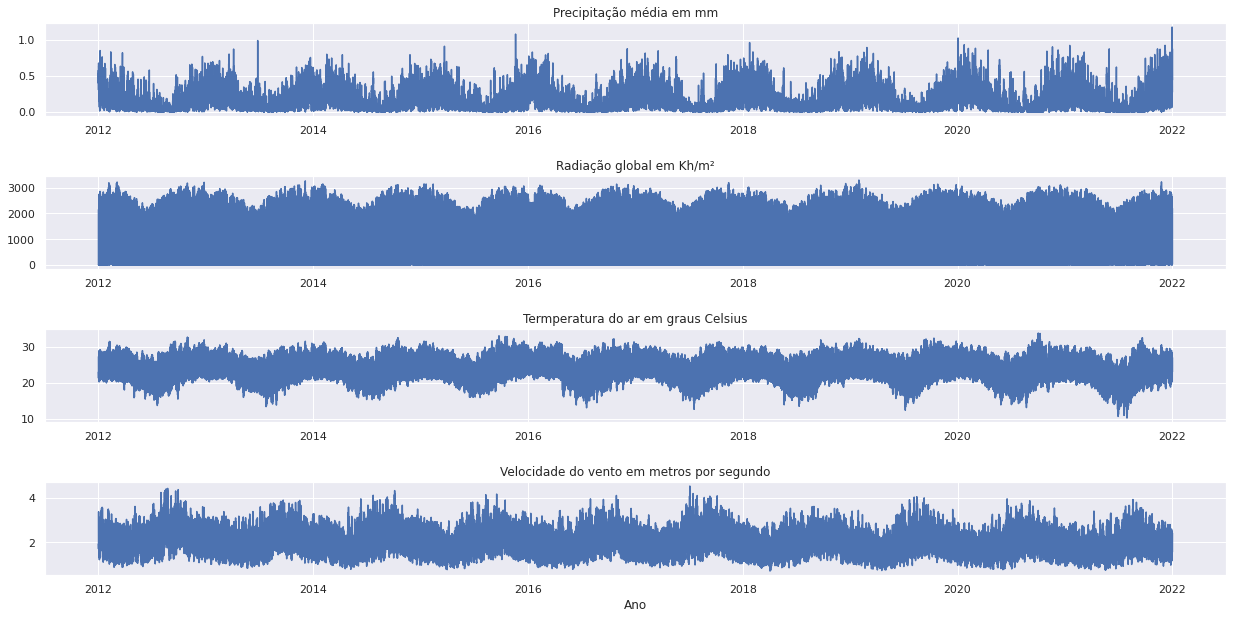

In [ ]:
#Como se comportam as variáveis climáticas no território nacional?

fig, ax = plt.subplots(4)
fig.set_size_inches(18, 9)
fig.tight_layout(pad=3.0)

ax[0].plot(df_tempo['PRECIPITACAO TOTAL, HORARIO(mm)'].groupby(df_tempo['Data Medicao']).mean())
ax[0].set_title('Precipitação média em mm')
ax[1].plot(df_tempo['RADIACAO GLOBAL(Kj/m²)'].groupby(df_tempo['Data Medicao']).mean())
ax[1].set_title('Radiação global em Kh/m²')
ax[2].plot(df_tempo['TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)'].groupby(df_tempo['Data Medicao']).mean())
ax[2].set_title('Termperatura do ar em graus Celsius')
ax[3].plot(df_tempo['VENTO, VELOCIDADE HORARIA(m/s)'].groupby(df_tempo['Data Medicao']).mean())
ax[3].set_title('Velocidade do vento em metros por segundo')
plt.xlabel("Ano")
plt.show()



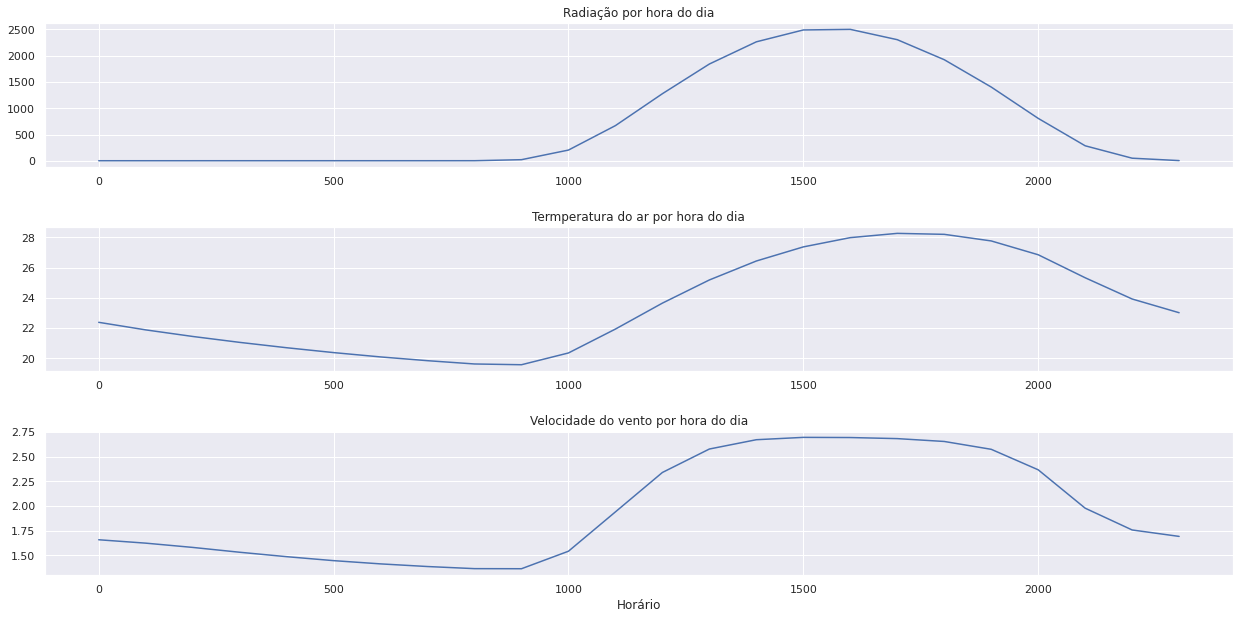

In [ ]:
#Como se comportam as variáveis ao longo do dia no território nacional?

fig, ax = plt.subplots(3)
fig.set_size_inches(18, 9)
fig.tight_layout(pad=3.0)

ax[0].plot(df_tempo['RADIACAO GLOBAL(Kj/m²)'].groupby(df_tempo['Hora Medicao']).mean())
ax[0].set_title('Radiação por hora do dia')
ax[1].plot(df_tempo['TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)'].groupby(df_tempo['Hora Medicao']).mean())
ax[1].set_title('Termperatura do ar por hora do dia')
ax[2].plot(df_tempo['VENTO, VELOCIDADE HORARIA(m/s)'].groupby(df_tempo['Hora Medicao']).mean())
ax[2].set_title('Velocidade do vento por hora do dia')
plt.xlabel("Horário")
plt.show()



In [ ]:
#elimnando a coluna Hora Medicao
df_tempo.drop(['Hora Medicao'],axis=1, inplace=True)

In [ ]:
#agrupando as variáveis e criando matriz de correlação
df_gr=df_tempo.groupby(df_tempo['Data Medicao']).mean()

df_term_gr=df_term.copy()
df_term_gr['Data Medicao'] =df_term_gr['din_instante'].dt.strftime('%Y-%m-%d')
df_term_gr['Data Medicao']  = pd.to_datetime(df_term_gr['Data Medicao'],format="%Y-%m-%d") 
df_term_gr=df_term_gr.groupby(df_term_gr['Data Medicao']).mean()

df_gr=pd.merge(df_gr,df_term_gr, how='left', on='Data Medicao')

del df_term_gr

corr_matrix=df_gr.corr()

del df_gr
corr_matrix['val_verifgeracao']


PRECIPITACAO TOTAL, HORARIO(mm)                0.009624
RADIACAO GLOBAL(Kj/m²)                         0.212381
TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)    0.052550
VENTO, VELOCIDADE HORARIA(m/s)                 0.262445
val_verifgeracao                               1.000000
Name: val_verifgeracao, dtype: float64

In [ ]:
#regioes no dataset de tempo
df_tempo['REGIAO'].unique()

array(['CO', nan, 'N', 'NE', 'SE', 'S'], dtype=object)

In [ ]:
# criar médias móveis para a precipitação
t0 = time.time()

df_tempo['REGIAO'].fillna('N/I', inplace=True)
df_tempo=df_tempo.groupby(['REGIAO','Data Medicao']).mean().reset_index()
t_temp=pd.DataFrame(df_tempo['Data Medicao'].unique()).rename(columns={0:'Data Medicao'})

roll=[720,2160,4320]

for i in range(len(df_tempo['REGIAO'].unique())):
  regiao=df_tempo['REGIAO'].unique()[i]
  t_temp0=df_tempo.loc[df_tempo['REGIAO']==df_tempo['REGIAO'].unique()[i]]
  for j in range(len(roll)):
   nome='PRECIP_'+str(int(roll[j]/24))+"D"
   t_temp0[nome]=t_temp0['PRECIPITACAO TOTAL, HORARIO(mm)'].rolling(roll[j]).mean()
  t_temp=pd.merge(t_temp,t_temp0,how='left',on='Data Medicao',suffixes=['','_'+regiao])

del t_temp0

df_tempo=t_temp

del t_temp
print(time.time()-t0)

df_tempo.drop(['REGIAO','REGIAO_N','REGIAO_N/I','REGIAO_NE','REGIAO_S','REGIAO_SE'],axis=1,inplace=True)

df_tempo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


10.978994369506836


,Data Medicao,"PRECIPITACAO TOTAL, HORARIO(mm)",RADIACAO GLOBAL(Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)","VENTO, VELOCIDADE HORARIA(m/s)",PRECIP_30D,PRECIP_90D,PRECIP_180D,"PRECIPITACAO TOTAL, HORARIO(mm)_N",RADIACAO GLOBAL(Kj/m²)_N,...,PRECIP_30D_S,PRECIP_90D_S,PRECIP_180D_S,"PRECIPITACAO TOTAL, HORARIO(mm)_SE",RADIACAO GLOBAL(Kj/m²)_SE,"TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)_SE","VENTO, VELOCIDADE HORARIA(m/s)_SE",PRECIP_30D_SE,PRECIP_90D_SE,PRECIP_180D_SE
0,2012-01-01 00:00:00,0.608451,-2.677946,22.651316,1.264474,NaN,NaN,NaN,0.100000,-2.589039,...,NaN,NaN,NaN,0.879612,-2.229255,21.773585,1.534615,NaN,NaN,NaN
1,2012-01-01 01:00:00,0.671429,-2.483904,22.446667,1.294667,NaN,NaN,NaN,0.004444,-2.983720,...,NaN,NaN,NaN,0.751456,-2.132708,21.578302,1.494231,NaN,NaN,NaN
2,2012-01-01 02:00:00,0.540000,-2.588945,22.288000,1.248000,NaN,NaN,NaN,0.017391,-2.905412,...,NaN,NaN,NaN,1.439604,-2.127221,21.429808,1.566667,NaN,NaN,NaN
3,2012-01-01 03:00:00,0.625714,-2.568397,22.045333,1.364000,NaN,NaN,NaN,0.004348,-2.988118,...,NaN,NaN,NaN,1.615842,-1.893981,21.281731,1.499020,NaN,NaN,NaN
4,2012-01-01 04:00:00,0.554286,-2.337616,21.941333,1.361333,NaN,NaN,NaN,0.004444,-2.891300,...,NaN,NaN,NaN,1.615842,-1.729087,21.219231,1.550980,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87667,2021-12-31 19:00:00,0.516279,1611.107098,26.676471,2.644898,0.329896,0.300691,0.160642,0.206667,1467.706179,...,0.074287,0.126970,0.134233,1.010811,792.265679,23.821552,2.334513,0.361567,0.300076,0.165141
87668,2021-12-31 20:00:00,0.260465,1138.783654,25.707843,2.585714,0.329442,0.300807,0.160702,2.062069,883.549704,...,0.074468,0.126964,0.134268,0.976786,490.092549,23.214530,2.115789,0.362691,0.300497,0.165367
87669,2021-12-31 21:00:00,0.786364,645.264415,24.950000,2.036000,0.329586,0.301171,0.160884,2.434483,577.595750,...,0.074774,0.127027,0.134322,0.560000,219.542505,22.583478,2.084821,0.362959,0.300739,0.165497
87670,2021-12-31 22:00:00,0.031818,224.349245,23.950000,1.602000,0.328848,0.301186,0.160892,1.406897,301.948143,...,0.075151,0.127130,0.134387,0.530909,57.484919,22.012174,1.946429,0.363121,0.300896,0.165620


In [ ]:
#verificar a correlação com as novas variáveis


df_term_gr=df_term.copy()
df_term_gr['Data Medicao'] =df_term_gr['din_instante'].dt.strftime('%Y-%m-%d')
df_term_gr['Data Medicao']  = pd.to_datetime(df_term_gr['Data Medicao'],format="%Y-%m-%d") 
df_term_gr=df_term_gr.groupby(df_term_gr['Data Medicao']).mean()

df_gr=pd.merge(df_tempo,df_term_gr, how='left', on='Data Medicao')

del df_term_gr

corr_matrix=df_gr.corr()

del df_gr
corr_matrix['val_verifgeracao'].sort_values()


PRECIP_180D_SE                                    -0.460174
PRECIP_180D                                       -0.377594
PRECIP_90D_NE                                     -0.364571
PRECIP_90D_N                                      -0.348165
PRECIP_180D_N                                     -0.341958
PRECIP_90D_N/I                                    -0.341630
PRECIP_90D_SE                                     -0.295203
PRECIP_30D_NE                                     -0.284626
PRECIP_90D                                        -0.266570
PRECIP_180D_N/I                                   -0.255322
PRECIP_30D_N                                      -0.246465
PRECIP_180D_NE                                    -0.241709
PRECIP_30D_N/I                                    -0.213783
PRECIP_30D_SE                                     -0.096844
RADIACAO GLOBAL(Kj/m²)_S                          -0.095164
PRECIPITACAO TOTAL, HORARIO(mm)_N                 -0.086260
PRECIPITACAO TOTAL, HORARIO(mm)_NE      

In [ ]:
df=pd.merge(df_term,df_tempo,left_on='din_instante',right_on='Data Medicao',validate='m:1')
df.drop(['Data Medicao',
         'PRECIPITACAO TOTAL, HORARIO(mm)',
         'PRECIPITACAO TOTAL, HORARIO(mm)_N',
         'PRECIPITACAO TOTAL, HORARIO(mm)_N/I',
         'PRECIPITACAO TOTAL, HORARIO(mm)_NE',
         'PRECIPITACAO TOTAL, HORARIO(mm)_S',
         'PRECIPITACAO TOTAL, HORARIO(mm)_SE'],axis=1,inplace=True)
del df_term
del df_tempo

## III. Preparação da base de dados   

In [ ]:
#criar conjunto de treino e teste
train_set=df.loc[df['din_instante']<='2019-12-31 23:00:00']
test_set=df.loc[df['din_instante']>'2019-12-31 23:00:00']
train_set.set_index('din_instante',inplace=True)
test_set.set_index('din_instante',inplace=True)

In [ ]:
#criar conjunto de testes e de treino
#from sklearn.model_selection import train_test_split

#train_set,test_set=train_test_split(df,test_size=0.2,random_state=42)


In [ ]:
print(len(train_set),len(train_set)/len(df))
print(len(test_set),len(test_set)/len(df))

244652 0.7770973356880583
70176 0.22290266431194175


In [ ]:
# Separar variáveis explicativas e os rótulos

x_variables=train_set.drop('val_verifgeracao',axis=1)
labels=train_set['val_verifgeracao']
len(x_variables)==len(labels)

True

In [ ]:
#verificando missing values
n=0
for i in x_variables.columns:
  if x_variables[i].isnull().values.any()==True:
    print(i,':',x_variables[i].isnull().values.any())


RADIACAO GLOBAL(Kj/m²) : True
TEMPERATURA DO AR - BULBO SECO, HORARIA(°C) : True
VENTO, VELOCIDADE HORARIA(m/s) : True
PRECIP_30D : True
PRECIP_90D : True
PRECIP_180D : True
PRECIP_180D_N : True
RADIACAO GLOBAL(Kj/m²)_N/I : True
TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)_N/I : True
VENTO, VELOCIDADE HORARIA(m/s)_N/I : True
PRECIP_30D_N/I : True
PRECIP_90D_N/I : True
PRECIP_180D_N/I : True
PRECIP_180D_NE : True


In [ ]:
#Esse é o nosso imputer
x_variables=x_variables.reset_index()
for i in x_variables.columns:
  if  x_variables[i].isnull().values.any():
     for j in range(1,13):
       m=x_variables['din_instante'].dt.month==j
       x_variables.loc[m,i]=x_variables.loc[m,i].fillna(x_variables.loc[m,i].notnull().median())
x_variables=x_variables.set_index('din_instante')


In [ ]:
#verificando se o imputer funcionou

for i in x_variables.columns:
  if x_variables[i].isnull().values.any()==True:
    print(i,':',x_variables[i].isnull().values.any())

In [ ]:
#OneHotEncoder

from sklearn.preprocessing import OneHotEncoder


#Escalonamento

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


#Pipeline com imputador usando estatégia da mediana escalonamento por padronização (normalização)

from sklearn.pipeline import Pipeline
num_pipeline=Pipeline([('st_scaler', StandardScaler())])

#Column Transformer

from sklearn.compose import ColumnTransformer

#Criando grupos de características numéricas e categóricas

num_att=list()
cat_att=list()

for i in x_variables.columns:
  if type(x_variables[i][1])==str:
    cat_att.append(i)
  else:
    num_att.append(i)

#Pipeline final

full_pipeline=ColumnTransformer([('num',num_pipeline,num_att),
                                 ('cat',OneHotEncoder(drop='first').fit(x_variables),cat_att)])

print(num_att)
print(cat_att)

['RADIACAO GLOBAL(Kj/m²)', 'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)', 'VENTO, VELOCIDADE HORARIA(m/s)', 'PRECIP_30D', 'PRECIP_90D', 'PRECIP_180D', 'RADIACAO GLOBAL(Kj/m²)_N', 'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)_N', 'VENTO, VELOCIDADE HORARIA(m/s)_N', 'PRECIP_30D_N', 'PRECIP_90D_N', 'PRECIP_180D_N', 'RADIACAO GLOBAL(Kj/m²)_N/I', 'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)_N/I', 'VENTO, VELOCIDADE HORARIA(m/s)_N/I', 'PRECIP_30D_N/I', 'PRECIP_90D_N/I', 'PRECIP_180D_N/I', 'RADIACAO GLOBAL(Kj/m²)_NE', 'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)_NE', 'VENTO, VELOCIDADE HORARIA(m/s)_NE', 'PRECIP_30D_NE', 'PRECIP_90D_NE', 'PRECIP_180D_NE', 'RADIACAO GLOBAL(Kj/m²)_S', 'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)_S', 'VENTO, VELOCIDADE HORARIA(m/s)_S', 'PRECIP_30D_S', 'PRECIP_90D_S', 'PRECIP_180D_S', 'RADIACAO GLOBAL(Kj/m²)_SE', 'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)_SE', 'VENTO, VELOCIDADE HORARIA(m/s)_SE', 'PRECIP_30D_SE', 'PRECIP_90D_SE', 'PRECIP_180D_SE']
['id_subsistema

In [ ]:
#criar matriz densa com características transformadas

x_variables_prepared=full_pipeline.fit_transform(x_variables)


In [ ]:
x_variables_prepared

array([[-0.77633979,  0.05430889, -0.53853941, ...,  0.        ,
         0.        ,  0.        ],
       [-0.77633979,  0.05430889, -0.53853941, ...,  1.        ,
         0.        ,  0.        ],
       [-0.77633979,  0.05430889, -0.53853941, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.12270323,  1.18988176,  0.42927851, ...,  0.        ,
         0.        ,  1.        ],
       [-0.44280297,  0.79552356, -0.60634126, ...,  0.        ,
         0.        ,  1.        ],
       [-0.74041626,  0.36897923, -0.81608704, ...,  0.        ,
         0.        ,  1.        ]])

# IV.Treinando os modelos

Serão treinados os seguintes modelos:

- Regressão Linear
- SVM
- Árvore de Decisão
- Floresta Aleatória
- Rede Neural Densa
- Rede Neural Recorrente (RNN)
- LSTM

In [ ]:
#gerando samples para realizar algumas predições
sample_x=x_variables.iloc[19:23]
sample_y=labels.iloc[19:23]
sample_x_prep=full_pipeline.fit_transform(sample_x)

#### Regressão Linear

In [ ]:
# treinando uma Regressão Linear
lin_reg=LinearRegression()
lin_reg.fit(x_variables_prepared,labels)

LinearRegression()

In [ ]:
#Rodando algumas previsões e comparando com os rótulos
print('Predictions:',list(lin_reg.predict(sample_x_prep)))
print('Labels:',list(sample_y))
print('Diff:',list(lin_reg.predict(sample_x_prep)-list(sample_y)))

Predictions: [6104.2030028539775, 1676.0310587883155, 2584.557611648569, 1067.4058937532056]
Labels: [5188.758, 312.7, 3068.41, 1873.809]
Diff: [915.4450028539777, 1363.3310587883154, -483.8523883514308, -806.4031062467943]


#### SVM

In [ ]:
## treinando o svm
from sklearn.svm import LinearSVR
svm_reg=LinearSVR(epsilon=1.5,random_state=42)
svm_reg.fit(x_variables_prepared,labels)

LinearSVR(epsilon=1.5, random_state=42)

In [ ]:
#Rodando algumas previsões e comparando com os rótulos
print('Predictions:',list(svm_reg.predict(sample_x_prep)))
print('Labels:',list(sample_y))
print('Diff:',list(svm_reg.predict(sample_x_prep)-list(sample_y)))

Predictions: [5890.315200380129, 1705.930039271285, 2554.3500057590363, 1071.3230545777988]
Labels: [5188.758, 312.7, 3068.41, 1873.809]
Diff: [701.557200380129, 1393.230039271285, -514.0599942409635, -802.4859454222012]


#### Decision Tree

In [ ]:
#treinando a árvore de decisão
tree_reg=DecisionTreeRegressor(max_depth=16,random_state=42)
tree_reg.fit(x_variables_prepared,labels)

DecisionTreeRegressor(max_depth=16, random_state=42)

In [ ]:
#Rodando algumas previsões e comparando com os rótulos
print('Predictions:',list(tree_reg.predict(sample_x_prep)))
print('Labels:',list(sample_y))
print('Diff:',list(tree_reg.predict(sample_x_prep)-list(sample_y)))

Predictions: [5066.941, 2058.7277272727274, 2541.847, 1281.4036333333331]
Labels: [5188.758, 312.7, 3068.41, 1873.809]
Diff: [-121.81700000000001, 1746.0277272727274, -526.5629999999996, -592.4053666666669]


#### Random Forest

In [ ]:
#treinando a random forest
rndf_reg=RandomForestRegressor(n_estimators=100, max_depth=16, random_state=42)
rndf_reg.fit(x_variables_prepared,labels)

RandomForestRegressor(max_depth=16, random_state=42)

In [ ]:
#Rodando algumas previsões e comparando com os rótulos
print('Predictions:',list(rndf_reg.predict(sample_x_prep)))
print('Labels:',list(sample_y))
print('Diff:',list(rndf_reg.predict(sample_x_prep)-list(sample_y)))

Predictions: [5763.929797931034, 1840.707281212469, 2585.145434571288, 1098.690091205721]
Labels: [5188.758, 312.7, 3068.41, 1873.809]
Diff: [575.1717979310342, 1528.007281212469, -483.26456542871165, -775.1189087942789]


#### ANN

In [ ]:
#ANN

ann_model=keras.models.Sequential(
    [
     keras.layers.Dense(128,activation='tanh',input_shape=x_variables_prepared.shape[1:], kernel_initializer="he_normal"),
     keras.layers.Dense(128,activation='tanh'),
     keras.layers.Dropout(0.3),
     keras.layers.Dense(1)   
    ]
)

ann_model.compile(loss="mse",optimizer="sgd", metrics=[tf.keras.metrics.RootMeanSquaredError()])

ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5120      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,761
Trainable params: 21,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ann_history=ann_model.fit(x_variables_prepared,
                  labels,
                  epochs=100,
                  batch_size=4096,
                  callbacks=[keras.callbacks.EarlyStopping(monitor='root_mean_squared_error',
                                                                                                  min_delta=0.1,
                                                                                                  patience=10,
                                                                                                  restore_best_weights=True)])

Epoch 1/100
60/60 [==============================] - 2s 3ms/step - loss: 5561144.0000 - root_mean_squared_error: 2358.2078
Epoch 2/100
60/60 [==============================] - 0s 3ms/step - loss: 3777640.0000 - root_mean_squared_error: 1943.6151
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 3452675.7500 - root_mean_squared_error: 1858.1377
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 3124958.7500 - root_mean_squared_error: 1767.7552
Epoch 5/100
60/60 [==============================] - 0s 3ms/step - loss: 3133148.0000 - root_mean_squared_error: 1770.0701
Epoch 6/100
60/60 [==============================] - 0s 3ms/step - loss: 2949400.5000 - root_mean_squared_error: 1717.3818
Epoch 7/100
60/60 [==============================] - 0s 3ms/step - loss: 2852583.5000 - root_mean_squared_error: 1688.9592
Epoch 8/100
60/60 [==============================] - 0s 3ms/step - loss: 2837653.7500 - root_mean_squared_error: 1684.5337
Epoch 9/100
60/6

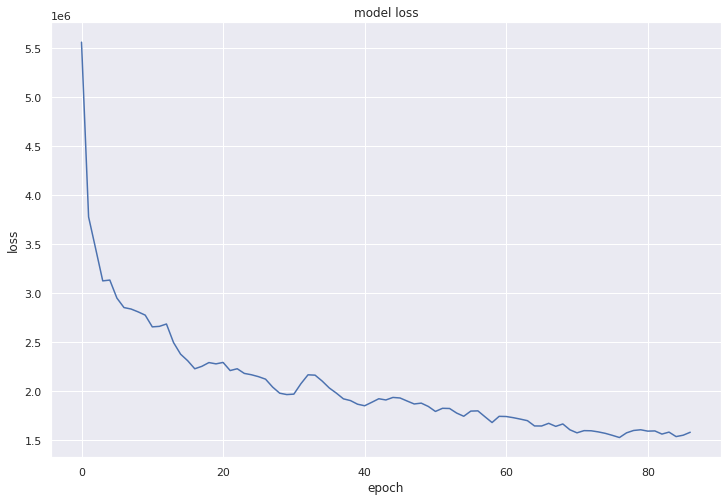

In [ ]:
# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(ann_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()




#### RNN Simples

In [ ]:
#RNN com layer final dense
rnn_model = keras.Sequential(
    [
    keras.layers.SimpleRNN(units=39, input_shape=(x_variables_prepared.shape[1],1), activation="tanh", return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.SimpleRNN(units=39, activation="tanh", return_sequences=False),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="linear")
    ]
)

rnn_model.compile(loss="mse", optimizer="adam", metrics=[tf.keras.metrics.RootMeanSquaredError()])

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 39, 39)            1599      
                                                                 
 dropout_1 (Dropout)         (None, 39, 39)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 39)                3081      
                                                                 
 dropout_2 (Dropout)         (None, 39)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 40        
                                                                 
Total params: 4,720
Trainable params: 4,720
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rnn_history = rnn_model.fit(
    x_variables_prepared, 
    labels, 
    epochs=100, 
    callbacks=[keras.callbacks.EarlyStopping(monitor='root_mean_squared_error', min_delta=0.1, patience=10, restore_best_weights=True)]
)

Epoch 1/100
7646/7646 [==============================] - 354s 46ms/step - loss: 12103822.0000 - root_mean_squared_error: 3479.0547
Epoch 2/100
7646/7646 [==============================] - 354s 46ms/step - loss: 10486677.0000 - root_mean_squared_error: 3238.3140
Epoch 3/100
7646/7646 [==============================] - 354s 46ms/step - loss: 8990374.0000 - root_mean_squared_error: 2998.3953
Epoch 4/100
7646/7646 [==============================] - 358s 47ms/step - loss: 7839982.5000 - root_mean_squared_error: 2799.9968
Epoch 5/100
7646/7646 [==============================] - 354s 46ms/step - loss: 6872023.0000 - root_mean_squared_error: 2621.4543
Epoch 6/100
7646/7646 [==============================] - 354s 46ms/step - loss: 6086684.5000 - root_mean_squared_error: 2467.1206
Epoch 7/100
7646/7646 [==============================] - 354s 46ms/step - loss: 5476862.0000 - root_mean_squared_error: 2340.2695
Epoch 8/100
7646/7646 [==============================] - 351s 46ms/step - loss: 5041970.

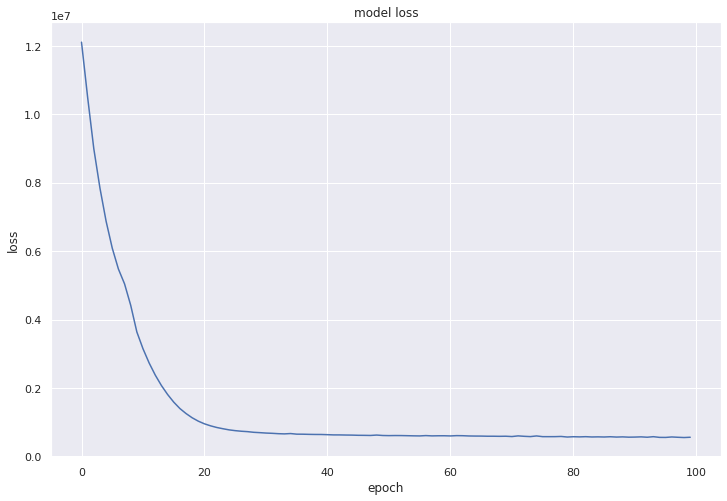

In [ ]:
# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(rnn_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#### LSTM

In [ ]:
#LSTM com Dense no final
lstm_model = keras.Sequential(
    [
    keras.layers.LSTM(units=39, input_shape=(x_variables_prepared.shape[1],1), activation="tanh", return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(units=39, activation="tanh", return_sequences=False),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="linear")
    ]
)

lstm_model.compile(loss="mse", optimizer="adam", metrics=[tf.keras.metrics.RootMeanSquaredError()])

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 39, 39)            6396      
                                                                 
 dropout (Dropout)           (None, 39, 39)            0         
                                                                 
 lstm_1 (LSTM)               (None, 39)                12324     
                                                                 
 dropout_1 (Dropout)         (None, 39)                0         
                                                                 
 dense (Dense)               (None, 1)                 40        
                                                                 
Total params: 18,760
Trainable params: 18,760
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_history = lstm_model.fit(
    x_variables_prepared, 
    labels, 
    epochs=100, 
    callbacks=[keras.callbacks.EarlyStopping(monitor='root_mean_squared_error', min_delta=0.1, patience=10, restore_best_weights=True)]
)

Epoch 1/100
7646/7646 [==============================] - 49s 6ms/step - loss: 11792142.0000 - root_mean_squared_error: 3433.9688
Epoch 2/100
7646/7646 [==============================] - 42s 5ms/step - loss: 10277955.0000 - root_mean_squared_error: 3205.9248
Epoch 3/100
7646/7646 [==============================] - 42s 6ms/step - loss: 8952818.0000 - root_mean_squared_error: 2992.1260
Epoch 4/100
7646/7646 [==============================] - 42s 5ms/step - loss: 7807800.5000 - root_mean_squared_error: 2794.2441
Epoch 5/100
7646/7646 [==============================] - 42s 6ms/step - loss: 6845859.0000 - root_mean_squared_error: 2616.4592
Epoch 6/100
7646/7646 [==============================] - 42s 6ms/step - loss: 6063777.5000 - root_mean_squared_error: 2462.4739
Epoch 7/100
7646/7646 [==============================] - 43s 6ms/step - loss: 5460269.0000 - root_mean_squared_error: 2336.7219
Epoch 8/100
7646/7646 [==============================] - 42s 6ms/step - loss: 5031200.0000 - root_mean

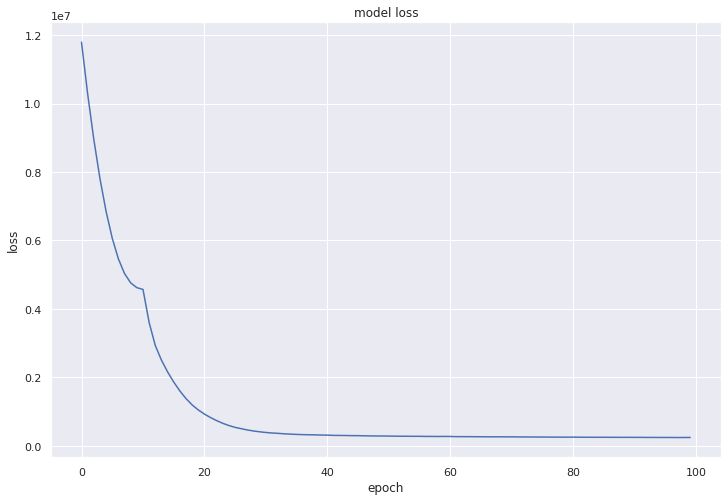

In [ ]:
# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(lstm_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#### Comparando as redes neurais

# V. Avaliação dos modelos                   


## Avaliação dos modelos na base de treino

Serão testados os modelos nas bases de treino e teste. O RMSE resultante do teste neste último servirá de critério de seleção dos melhores modelos.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [ ]:
#preparando o conjunto de teste
x_test=test_set.drop('val_verifgeracao',axis=1)
y_test=test_set['val_verifgeracao']

x_test=x_test.reset_index()
for i in x_test.columns:
  if  x_test[i].isnull().values.any():
     for j in range(1,13):
       m=x_test['din_instante'].dt.month==j
       x_test.loc[m,i]=x_test.loc[m,i].fillna(x_test.loc[m,i].notnull().median())
x_test=x_test.set_index('din_instante')

x_test_prep=full_pipeline.fit_transform(x_test)

In [ ]:
# função de apresentação dos Scores
def display_scores(scores):
  print('Scores:',scores)
  print('Mean:',scores.mean())
  print('Standard deviation:',scores.std())


In [ ]:
#lista dos modelos
modelos=[lin_reg, tree_reg, svm_reg, rndf_reg, ann_model, rnn_model, lstm_model]

In [ ]:
#Avaliando os modelos na base de treino
for m in modelos:
  predictions=m.predict(x_variables_prepared)
  mse=mean_squared_error(labels, predictions)
  rmse=np.sqrt(mse)
  print(m,':',rmse)

LinearRegression() : 906.4555070137402
DecisionTreeRegressor(max_depth=16, random_state=42) : 187.41925650070345
LinearSVR(epsilon=1.5, random_state=42) : 927.6268338930311
RandomForestRegressor(max_depth=16, random_state=42) : 148.42565268344168
<keras.engine.sequential.Sequential object at 0x7fc513463990> : 1164.1387541797892
<keras.engine.sequential.Sequential object at 0x7fc51035d090> : 521.3574550216397
<keras.engine.sequential.Sequential object at 0x7fc510420f90> : 366.5461218529605


## Avaliação dos modelos no conjunto de testes

In [ ]:
#Avaliando os modelos baseline na base de teste
m1=[lin_reg, tree_reg, svm_reg, rndf_reg]

for m in m1:
  predictions=m.predict(x_test_prep)
  mse=mean_squared_error(y_test,predictions)
  rmse=np.sqrt(mse)
  print(m,':',rmse)

LinearRegression() : 1485.680571688411
DecisionTreeRegressor(max_depth=16, random_state=42) : 1794.419871859778
LinearSVR(epsilon=1.5, random_state=42) : 1396.1696963247296
RandomForestRegressor(max_depth=16, random_state=42) : 1501.7027954079406


In [ ]:
#Avaliando modelos de DL na base de teste
m2=[ann_model, rnn_model, lstm_model]

for m in m2:
  m.evaluate(x_test_prep, y_test)

2193/2193 [==============================] - 8s 3ms/step - loss: 2011455.1250 - root_mean_squared_error: 1418.2578


Os modelos apresentaram RMSEs superiores a 1300 em todos os casos, o que podemos considerar alto quando comparado com algumas das observações do despacho térmico, principalmente os da Região Norte do Brasil. Ainda assim as redes neurais performaram bem, comparativamente aos modelos *baseline*, sendo que as redes neurais recorrentes (RNN e LSTM) chegaram a superar a Floresta Aleatória.

A inserção, no futuro, de variáveis adicionais, tais como o despacho defasado, pode melhorar a performance dos modelos. Para fins deste trabalho, entretanto, consideramos que o objetivo de estabelecer uma previsão a partir dos dados meteorológicos foi atingida, ainda que com um erro elevado.

## Seleção dos modelos

Decidimos salvar os modelos que performaram com RMSE inferior a 1500

In [ ]:
jb.dump(lin_reg, 'saved models/lin_reg.joblib')

['saved models/lin_reg.joblib']

In [ ]:
jb.dump(svm_reg, 'saved models/svm_reg.joblib')

['saved models/svm_reg.joblib']

In [ ]:
rnn_model.save('saved models/rnn_model3.h5')

In [ ]:
lstm_model.save('saved models/lstm_model3.h5')

# Conclusão

As variáveis meteorológicas, apesar de apresentarem correlação com o despacho térmico, não são suficientes para criar modelos que possuam baixo erro de previsão. 

Uma melhoria possível seria trabalhar com dados do despacho defasado, contudo esta não foi a proposição inicial deste trabalho.

# VI. Deployment

+ Plan deployment: 
+ Plan monitoring and maintenance: 
+ Produce final report: 
+ Review project: 

In [ ]:
import panel as pn
pn.extension(sizing_mode="stretch_width")
from bokeh.models.formatters import PrintfTickFormatter
import param
import holoviews as hv
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

In [ ]:
#salva os parâmetros e labels da base de teste para importação no deploy
x_test.to_csv("Deploy/x_test.csv", index=False, encoding='UTF-8')
y_test_para_csv = test_set[['id_subsistema', 'val_verifgeracao']]
y_test_para_csv.to_csv("Deploy/y_test.csv", index=False, encoding='UTF-8')

In [ ]:
#RODAR APENAS SE NECESSÁRIO - reimporta os modelos treinados e as bases de dados
x_test = pd.read_csv('Deploy/x_test.csv')
x_test_prep=full_pipeline.fit_transform(x_test)
y_test = pd.read_csv('Deploy/y_test.csv')
lin_reg = jb.load('Deploy/lin_reg.joblib')
svm_reg = jb.load('Deploy/svm_reg.joblib')
rnn_model = keras.models.load_model('Deploy/rnn_model3.h5')
lstm_model = keras.models.load_model('Deploy/lstm_model3.h5')

In [ ]:
#gera as dropdowns e os sliders
subsistema_drop=pn.widgets.Select(name='Subsistema', options=['Norte', 'Nordeste', 'Sudeste', 'Sul'], margin=(0, 5, 5, 10))
modelo_drop=pn.widgets.Select(name='Escolha o Modelo', options=["Regressão Linear", "SVM", "RNN", "LSTM"], margin=(0, 5, 5, 10))

slider_1 = pn.widgets.FloatSlider(name="CO", start=x_test[x_test.columns[1]].min(), end=x_test[x_test.columns[1]].max(), step=0.01, value=x_test[x_test.columns[1]].mean())
slider_2 = pn.widgets.FloatSlider(name="CO", start=x_test[x_test.columns[2]].min(), end=x_test[x_test.columns[2]].max(), step=0.01, value=x_test[x_test.columns[2]].mean())
slider_3 = pn.widgets.FloatSlider(name="CO", start=x_test[x_test.columns[3]].min(), end=x_test[x_test.columns[3]].max(), step=0.01, value=x_test[x_test.columns[3]].mean())
slider_4 = pn.widgets.FloatSlider(name="CO", start=x_test[x_test.columns[4]].min(), end=x_test[x_test.columns[4]].max(), step=0.01, value=x_test[x_test.columns[4]].mean())
slider_5 = pn.widgets.FloatSlider(name="CO", start=x_test[x_test.columns[5]].min(), end=x_test[x_test.columns[5]].max(), step=0.01, value=x_test[x_test.columns[5]].mean())
slider_6 = pn.widgets.FloatSlider(name="CO", start=x_test[x_test.columns[6]].min(), end=x_test[x_test.columns[6]].max(), step=0.01, value=x_test[x_test.columns[6]].mean())
slider_7 = pn.widgets.FloatSlider(name=str(x_test.columns[9])[-1:], start=x_test[x_test.columns[7]].min(), end=x_test[x_test.columns[7]].max(), step=0.01, value=x_test[x_test.columns[7]].mean())
slider_8 = pn.widgets.FloatSlider(name=str(x_test.columns[9])[-1:], start=x_test[x_test.columns[8]].min(), end=x_test[x_test.columns[8]].max(), step=0.01, value=x_test[x_test.columns[8]].mean())
slider_9 = pn.widgets.FloatSlider(name=str(x_test.columns[9])[-1:], start=x_test[x_test.columns[9]].min(), end=x_test[x_test.columns[9]].max(), step=0.01, value=x_test[x_test.columns[9]].mean())
slider_10 = pn.widgets.FloatSlider(name=str(x_test.columns[10])[-1:], start=x_test[x_test.columns[10]].min(), end=x_test[x_test.columns[10]].max(), step=0.01, value=x_test[x_test.columns[10]].mean())
slider_11= pn.widgets.FloatSlider(name=str(x_test.columns[11])[-1:], start=x_test[x_test.columns[11]].min(), end=x_test[x_test.columns[11]].max(), step=0.01, value=x_test[x_test.columns[11]].mean())
slider_12 = pn.widgets.FloatSlider(name=str(x_test.columns[12])[-1:], start=x_test[x_test.columns[12]].min(), end=x_test[x_test.columns[12]].max(), step=0.01, value=x_test[x_test.columns[12]].mean())
slider_13 = pn.widgets.FloatSlider(name=str(x_test.columns[13])[-3:], start=x_test[x_test.columns[13]].min(), end=x_test[x_test.columns[13]].max(), step=0.01, value=x_test[x_test.columns[13]].mean())
slider_14 = pn.widgets.FloatSlider(name=str(x_test.columns[14])[-3:], start=x_test[x_test.columns[14]].min(), end=x_test[x_test.columns[14]].max(), step=0.01, value=x_test[x_test.columns[14]].mean())
slider_15 = pn.widgets.FloatSlider(name=str(x_test.columns[15])[-3:], start=x_test[x_test.columns[15]].min(), end=x_test[x_test.columns[15]].max(), step=0.01, value=x_test[x_test.columns[15]].mean())
slider_16 = pn.widgets.FloatSlider(name=str(x_test.columns[16])[-3:], start=x_test[x_test.columns[16]].min(), end=x_test[x_test.columns[16]].max(), step=0.01, value=x_test[x_test.columns[16]].mean())
slider_17 = pn.widgets.FloatSlider(name=str(x_test.columns[17])[-3:], start=x_test[x_test.columns[17]].min(), end=x_test[x_test.columns[17]].max(), step=0.01, value=x_test[x_test.columns[17]].mean())
slider_18 = pn.widgets.FloatSlider(name=str(x_test.columns[18])[-3:], start=x_test[x_test.columns[18]].min(), end=x_test[x_test.columns[18]].max(), step=0.01, value=x_test[x_test.columns[18]].mean())
slider_19 = pn.widgets.FloatSlider(name=str(x_test.columns[19])[-2:], start=x_test[x_test.columns[19]].min(), end=x_test[x_test.columns[19]].max(), step=0.01, value=x_test[x_test.columns[19]].mean())
slider_20 = pn.widgets.FloatSlider(name=str(x_test.columns[20])[-2:], start=x_test[x_test.columns[20]].min(), end=x_test[x_test.columns[20]].max(), step=0.01, value=x_test[x_test.columns[20]].mean())
slider_21 = pn.widgets.FloatSlider(name=str(x_test.columns[21])[-2:], start=x_test[x_test.columns[21]].min(), end=x_test[x_test.columns[21]].max(), step=0.01, value=x_test[x_test.columns[21]].mean())
slider_22 = pn.widgets.FloatSlider(name=str(x_test.columns[22])[-2:], start=x_test[x_test.columns[22]].min(), end=x_test[x_test.columns[22]].max(), step=0.01, value=x_test[x_test.columns[22]].mean())
slider_23 = pn.widgets.FloatSlider(name=str(x_test.columns[23])[-2:], start=x_test[x_test.columns[23]].min(), end=x_test[x_test.columns[23]].max(), step=0.01, value=x_test[x_test.columns[23]].mean())
slider_24 = pn.widgets.FloatSlider(name=str(x_test.columns[24])[-2:], start=x_test[x_test.columns[24]].min(), end=x_test[x_test.columns[24]].max(), step=0.01, value=x_test[x_test.columns[24]].mean())
slider_25 = pn.widgets.FloatSlider(name=str(x_test.columns[25])[-1:], start=x_test[x_test.columns[25]].min(), end=x_test[x_test.columns[25]].max(), step=0.01, value=x_test[x_test.columns[25]].mean())
slider_26 = pn.widgets.FloatSlider(name=str(x_test.columns[26])[-1:], start=x_test[x_test.columns[26]].min(), end=x_test[x_test.columns[26]].max(), step=0.01, value=x_test[x_test.columns[26]].mean())
slider_27 = pn.widgets.FloatSlider(name=str(x_test.columns[27])[-1:], start=x_test[x_test.columns[27]].min(), end=x_test[x_test.columns[27]].max(), step=0.01, value=x_test[x_test.columns[27]].mean())
slider_28 = pn.widgets.FloatSlider(name=str(x_test.columns[28])[-1:], start=x_test[x_test.columns[28]].min(), end=x_test[x_test.columns[28]].max(), step=0.01, value=x_test[x_test.columns[28]].mean())
slider_29 = pn.widgets.FloatSlider(name=str(x_test.columns[29])[-1:], start=x_test[x_test.columns[29]].min(), end=x_test[x_test.columns[29]].max(), step=0.01, value=x_test[x_test.columns[29]].mean())
slider_30 = pn.widgets.FloatSlider(name=str(x_test.columns[30])[-1:], start=x_test[x_test.columns[30]].min(), end=x_test[x_test.columns[30]].max(), step=0.01, value=x_test[x_test.columns[30]].mean())
slider_31 = pn.widgets.FloatSlider(name=str(x_test.columns[31])[-2:], start=x_test[x_test.columns[31]].min(), end=x_test[x_test.columns[31]].max(), step=0.01, value=x_test[x_test.columns[31]].mean())
slider_32 = pn.widgets.FloatSlider(name=str(x_test.columns[32])[-2:], start=x_test[x_test.columns[32]].min(), end=x_test[x_test.columns[32]].max(), step=0.01, value=x_test[x_test.columns[32]].mean())
slider_33 = pn.widgets.FloatSlider(name=str(x_test.columns[33])[-2:], start=x_test[x_test.columns[33]].min(), end=x_test[x_test.columns[33]].max(), step=0.01, value=x_test[x_test.columns[33]].mean())
slider_34 = pn.widgets.FloatSlider(name=str(x_test.columns[34])[-2:], start=x_test[x_test.columns[34]].min(), end=x_test[x_test.columns[34]].max(), step=0.01, value=x_test[x_test.columns[34]].mean())
slider_35 = pn.widgets.FloatSlider(name=str(x_test.columns[35])[-2:], start=x_test[x_test.columns[35]].min(), end=x_test[x_test.columns[35]].max(), step=0.01, value=x_test[x_test.columns[35]].mean())
slider_36 = pn.widgets.FloatSlider(name=str(x_test.columns[36])[-2:], start=x_test[x_test.columns[36]].min(), end=x_test[x_test.columns[36]].max(), step=0.01, value=x_test[x_test.columns[36]].mean())

seletor=pn.Column(
    'RADIACAO GLOBAL(Kj/m²)',
    pn.layout.Divider(margin=(-20, 0, 0, 0)),
    pn.Row(slider_1, slider_7, slider_13, slider_19, slider_25, slider_31),
    'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)',
    pn.layout.Divider(margin=(-20, 0, 0, 0)),
    pn.Row(slider_2, slider_8, slider_14, slider_20, slider_26, slider_32),
    'VENTO, VELOCIDADE HORARIA(m/s)',
    pn.layout.Divider(margin=(-20, 0, 0, 0)),
    pn.Row(slider_3, slider_9, slider_15, slider_21, slider_27, slider_33),
    'PRECIPAÇÃO ACUMULADA 30 DIAS',
    pn.layout.Divider(margin=(-20, 0, 0, 0)),
    pn.Row(slider_4, slider_10, slider_16, slider_22, slider_28, slider_34),
    'PRECIPAÇÃO ACUMULADA 90 DIAS',
    pn.layout.Divider(margin=(-20, 0, 0, 0)),
    pn.Row(slider_5, slider_11, slider_17, slider_23, slider_29, slider_35),
    'PRECIPAÇÃO ACUMULADA 180 DIAS',
    pn.layout.Divider(margin=(-20, 0, 0, 0)),
    pn.Row(slider_6, slider_12, slider_18, slider_24, slider_30, slider_36),
)


In [ ]:
#gera o botão para calcular o despacho térmico
class ActionExample(param.Parameterized):

    action = param.Action(lambda x: x.param.trigger('action'), label='Calcular Despacho')
    
    resposta = pn.indicators.Number(name='Despacho Térmico', value=0,font_size='27pt')
        
    @param.depends('action')
    def predicao(self):
      x_test2=x_test.copy()

      if subsistema_drop.value=='Nordeste':
        subsis='NE'
      elif subsistema_drop.value=='Sul':
        subsis='S'
      elif subsistema_drop.value=='Sudeste':
        subsis='SE'
      else:
        subsis='N'

      x_test2.loc[len(x_test2)]= np.array([subsis,slider_1.value, slider_2.value, slider_3.value, slider_4.value, slider_5.value, slider_6.value,
          slider_7.value, slider_8.value, slider_9.value, slider_10.value, slider_11.value, slider_12.value,
          slider_13.value, slider_14.value, slider_15.value, slider_16.value, slider_17.value, slider_18.value,
          slider_19.value, slider_20.value, slider_21.value, slider_22.value, slider_23.value, slider_24.value,
          slider_25.value, slider_26.value, slider_27.value, slider_28.value, slider_29.value, slider_30.value,
          slider_31.value, slider_32.value, slider_33.value, slider_34.value, slider_35.value, slider_36.value])

      input_prep=full_pipeline.fit_transform(x_test2)[len(x_test2)-1]
      input_prep=input_prep.reshape(1,-1)

      dict_modelo={"Regressão Linear":lin_reg, "SVM":svm_reg, "RNN":rnn_model, "LSTM":lstm_model}

      if modelo_drop.value=="Regressão Linear" or modelo_drop.value=="SVM":
        self.resposta.value=round(dict_modelo[modelo_drop.value].predict(input_prep)[0],2)
      else:
        self.resposta.value=round(float(dict_modelo[modelo_drop.value].predict(input_prep)[0][0]),2)
      return self.resposta
    
action_example = ActionExample()
component = pn.Column(
    pn.Column(
        pn.Column(pn.panel(action_example, show_name=False, margin=0, widgets={"action": {"button_type": "primary"}, "resposta": {"disabled": False}})),
        pn.panel(action_example.predicao, width=300), max_width=600)
)

In [ ]:
#função para gerar e salvar os plots por modelo e subsistema
def plot_predict2(modelo, subsistema):
  if subsistema=='Nordeste':
    label_panel = y_test[y_test['id_subsistema']=='NE']
    x_prep_panel = x_test_prep[x_test_prep[:,36]==1]
  elif subsistema=='Sul':
    label_panel = y_test[y_test['id_subsistema']=='S']
    x_prep_panel = x_test_prep[x_test_prep[:,37]==1]
  elif subsistema=='Sudeste':
    label_panel = y_test[y_test['id_subsistema']=='SE']
    x_prep_panel = x_test_prep[x_test_prep[:,38]==1]
  else:
    label_panel = y_test[y_test['id_subsistema']=='N']
    x_test_prep_not_ne = x_test_prep[x_test_prep[:,36]==0]
    x_test_prep_not_ne_s = x_test_prep_not_ne[x_test_prep_not_ne[:,37]==0]
    x_prep_panel = x_test_prep_not_ne_s[x_test_prep_not_ne_s[:,38]==0]
  
  if modelo=='Regressão Linear':
    panel_predict = lin_reg.predict(x_prep_panel)
  elif modelo=='SVM':
    panel_predict = svm_reg.predict(x_prep_panel)
  elif modelo=='RNN':
    panel_predict = rnn_model.predict(x_prep_panel)
  else:
    panel_predict = lstm_model.predict(x_prep_panel)
  
  fig, ax = plt.subplots(figsize=(12,9))
  ax.plot(label_panel.index, label_panel['val_verifgeracao'], zorder=1)
  ax.plot(label_panel.index, panel_predict, 'r--', zorder=-1)
  ax.set_xlabel('tempo')
  ax.set_ylabel('MWh')
  ax.set_title("Previsão do Despacho Térmico para a Região " + subsistema, fontdict={'fontsize': 14, 'fontweight': 'bold'})
  ax.legend(['Label', modelo])
  
  

  return plt.savefig(str(modelo)+'_'+str(subsistema)+'.png')

In [ ]:
#RODAR APENAS SE NECESSÁRIO - loop para gerar todos os plots da função acima
modelos=["Regressão Linear", "SVM", "RNN", "LSTM"]
subsistemas=['Norte', 'Nordeste', 'Sudeste', 'Sul']

for i in modelos:
    for j in subsistemas:
        plot_predict2(i,j)

In [ ]:
#gera o elemento gráfico com interação com as dropdowns
def plot_predict3(modelo, subsistema):
    modelo = modelo_drop.value
    subsistema = subsistema_drop.value
    grafico1 = pn.pane.PNG(str(modelo_drop.value)+'_'+str(subsistema_drop.value)+'.png', width=800)
    return grafico1

graf_pred = pn.interact(plot_predict3, modelo = modelo_drop, subsistema = subsistema_drop)

BootstrapTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [140352955569488] Row(background='WhiteSmoke', margin=(10, 10, 10, 10), sizing_mode='stretch_width')
        [0] Column(sizing_mode='stretch_width')
            [0] Card(margin=(10, 10, 10, 10), sizing_mode='stretch_width', title='Como usar esse painel')
                [0] Markdown(str, margin=(10, 10), sizing_mode='stretch_width')
                [1] Markdown(str, margin=(10, 10), sizing_mode='stretch_width')
                [2] Markdown(str, margin=(10, 10), sizing_mode='stretch_width')
                [3] Markdown(str, margin=(10, 10), sizing_mode='stretch_width')
                [4] Markdown(str, margin=(10, 10), sizing_mode='stretch_width')
                [5] Markdown(str, margin=(10, 10), sizing_mode='stretch_width')
                [6] Markdown(str, margin=(10, 10), sizing_mode='stretch_width')
            [1] Select(margin=(0, 5, 5, 10), name='Escolha o Modelo', options=['Regressão Linear', ...], sizing_mode='stretch_width', value='Regressão Linear')
            [2] Select(margin=(0, 5, 5, 10), name='Subsistema', options=['Norte', 'Nordeste', ...], sizing_mode='stretch_width', value='Norte')
            [3] Column(sizing_mode='stretch_width')
                [0] Column(max_width=600, sizing_mode='stretch_width')
                    [0] Column(sizing_mode='stretch_width')
                        [0] Button(button_type='primary', name='Calcular Despacho', sizing_mode='stretch_width')
                    [1] ParamMethod(method, sizing_mode='stretch_width', width=300)
        [1] Column(margin=(10, 10, 10, 10), sizing_mode='stretch_width')
            [0] Row(sizing_mode='stretch_width')
                [0] PNG(str, sizing_mode='stretch_width', width=800)
    [140352955476240] Row(background='WhiteSmoke', margin=(10, 10, 10, 10), sizing_mode='stretch_width')
        [0] Card(margin=(10, 10, 10, 10), sizing_mode='stretch_width', title='Parâmetros Meteorológicos...)
            [0] Column(margin=(10, 10), sizing_mode='stretch_width')
                [0] Markdown(str, sizing_mode='stretch_width')
                [1] Divider(margin=(-20, 0, 0, 0), sizing_mode='stretch_width')
                [2] Row(sizing_mode='stretch_width')
                    [0] FloatSlider(end=3427.2823396226418, name='CO', sizing_mode='stretch_width', start=-3.3202241379310347, step=0.01, value=765.828566347036)
                    [1] FloatSlider(end=3194.32740625, name='N', sizing_mode='stretch_width', start=-3.055333333333333, step=0.01, value=720.331073047414)
                    [2] FloatSlider(end=4147.82, name='N/I', sizing_mode='stretch_width', start=-3.6, step=0.01, value=364.32884997718475)
                    [3] FloatSlider(end=3390.750621052632, name='NE', sizing_mode='stretch_width', start=-3.520382978723404, step=0.01, value=798.9411818915092)
                    [4] FloatSlider(end=3764.416698412698, name='S', sizing_mode='stretch_width', start=-3.5451206896551724, step=0.01, value=709.619596042664)
                    [5] FloatSlider(end=3553.1682666666666, name='SE', sizing_mode='stretch_width', start=-3.374727272727273, step=0.01, value=742.6804808824475)
                [3] Markdown(str, sizing_mode='stretch_width')
                [4] Divider(margin=(-20, 0, 0, 0), sizing_mode='stretch_width')
                [5] Row(sizing_mode='stretch_width')
                    [0] FloatSlider(end=38.471428571428575, name='CO', sizing_mode='stretch_width', start=5.983673469387755, step=0.01, value=24.092595417267678)
                    [1] FloatSlider(end=35.43333333333333, name='N', sizing_mode='stretch_width', start=17.65, step=0.01, value=26.324240209847545)
                    [2] FloatSlider(end=39.1, name='N/I', sizing_mode='stretch_width', step=0.01, value=12.6525507295944)
                    [3] FloatSlider(end=35.672463768115946, name='NE', sizing_m
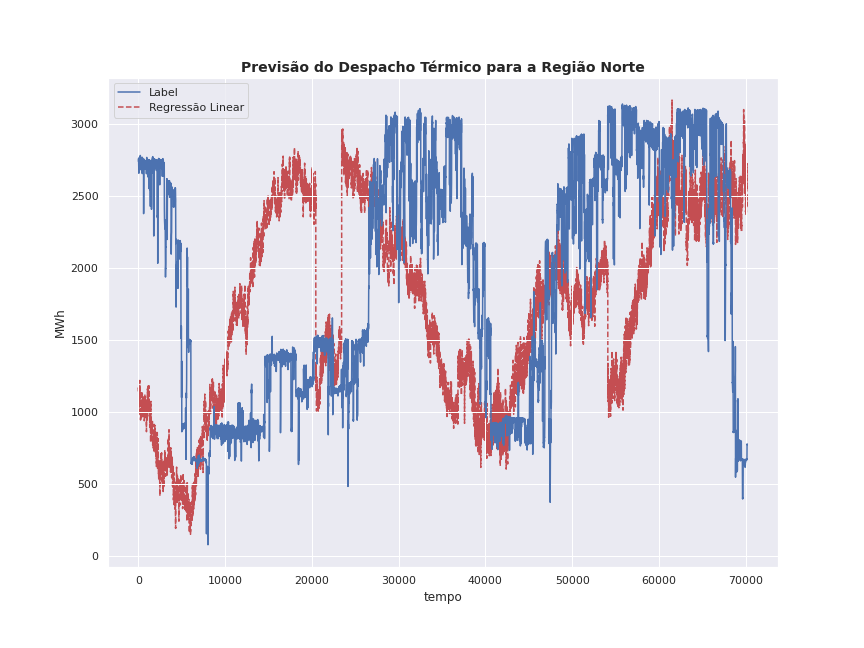

In [ ]:
#define o painel
bootstrap = pn.template.BootstrapTemplate(title='MFEE FGV - Trabalho de Deep Learning - Rodrigo Fonseca e Sandro Mendes')

bootstrap.main.append(
    pn.Row(
            pn.Column(
                pn.Card(
                    'O objetivo deste painel é predizer a necessidade de despacho térmico para uma hora, em determinado subsistema elétrico, dados os parâmetros climáticos.',
                    'Para realizar as predições, siga os passos abaixo.',
                    '1.Ajuste os parâmetros meteorológicos',
                    '2.Escolha um subsistema e um modelo de previsão',
                    '3.Clique em "Calcular Despacho"',
                    '*Os parâmetros meteorológicos estão por região do país, sendo N/I o valor obtido em estaçôes meteorológicas de regiões não identificadas.',
                    '**Os valores iniciais representam as médias observadas nas estações automáticas distribuídas pelo país.',
                    title='Como usar esse painel',
                    margin=(10,10,10,10)
                ),
                modelo_drop, 
                subsistema_drop, 
                component
            ),
            pn.Column(graf_pred[1], margin=(10,10,10,10)),
    background='WhiteSmoke',
    margin=(10,10,10,10)    
    )                                
)

bootstrap.main.append(
    pn.Row(
        pn.Card(seletor, margin=(10,10,10,10), title="Parâmetros Meteorológicos"),
        margin=(10,10,10,10),
        background='WhiteSmoke'
    )
)

bootstrap.servable()

In [ ]:
#chama o painel no localhost
pn.serve(bootstrap)

Launching server at http://localhost:40935
